In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

**U-Net model**

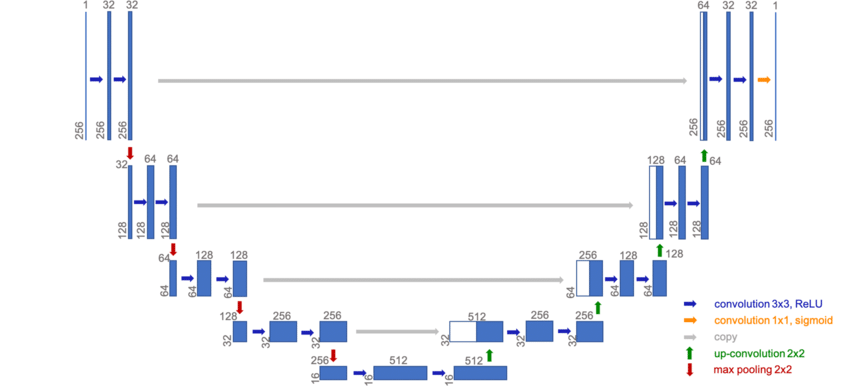

**Definisanje funkcija za kreiranje U-Net modela**

In [2]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [3]:
!pip install patchify

In [4]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
from keras.optimizers import Adam

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# učitavanje slika sa drive-a
large_image_stack = tiff.imread('/content/drive/MyDrive/Segmentation/mitochondria/training_images.tif')
large_mask_stack = tiff.imread('/content/drive/MyDrive/Segmentation/mitochondria/training_masks.tif')


In [30]:
all_img_patches = []

for img in range(large_image_stack.shape[0]):

    large_image = large_image_stack[img]

    patches_img = patchify(large_image, (256, 256), step=256)
    # patchify da bi podelili slike na (256,256) sa stepom 256 da ne bi doslo do preklapanja
    # delimo sliku na grid 3x3 i uzimamo te patch-eve kao nove slike

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.0

            all_img_patches.append(single_patch_img)


images = np.array(all_img_patches)
images = np.expand_dims(images, -1)

In [8]:
all_mask_patches = []
for img in range(large_mask_stack.shape[0]):

    large_mask = large_mask_stack[img]

    patches_mask = patchify(large_mask, (256, 256), step=256)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask / 255.

            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)

In [9]:
masks.shape

(1980, 256, 256, 1)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.25, random_state = 0)

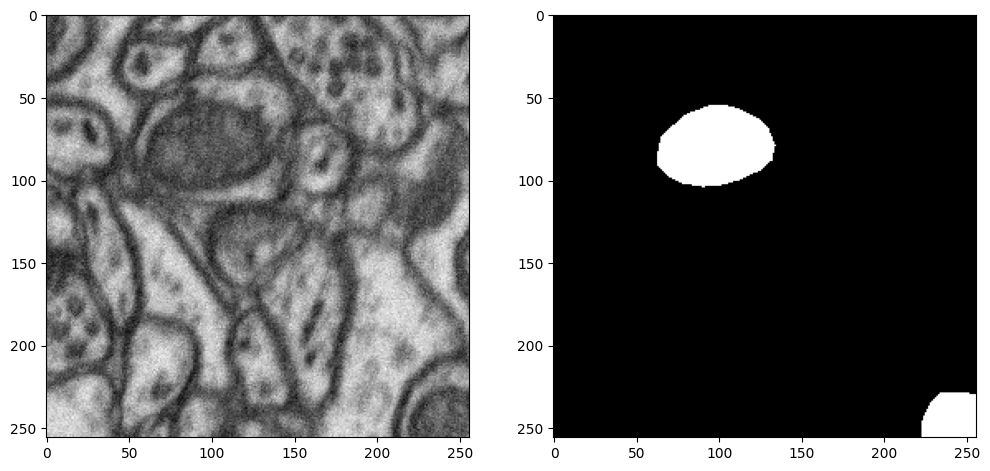

In [11]:
# prikaz originalne slike i originalne maske
import random

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [12]:
IMG_HEIGHT = images.shape[1]
IMG_WIDTH  = images.shape[2]
IMG_CHANNELS = images.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
# binary_crossentropy kao loss jer je u pitanju semanticka segmentacija jedne klase

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [13]:
# preprocessing_function u mask_data_gen_args kao lambda funkcija da ne bi prilikom
# shear(smicanja) interpolacijom doslo do generisanja novih vrednosti izmedju 0 i 1

seed=24 # seed kao osiguranje da prilikom data augmentacije slike maska odgovara slici

from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

batch_size = 8

image_data_generator = ImageDataGenerator(**img_data_gen_args)

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)


In [14]:
# funkcija za kreiranje generatora slike i maske
def image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = image_mask_generator(image_generator, mask_generator)

validation_datagen = image_mask_generator(valid_img_generator, valid_mask_generator)


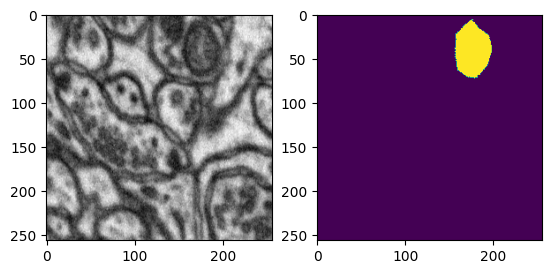

In [15]:
# prikaz slike i maske iz generatora
x = image_generator.next()
y = mask_generator.next()

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [16]:
# (train_length // batch_size), ali  x 3 jer koristimo data augmentaciju
steps_per_epoch = 3*(len(X_train))//batch_size

In [23]:
from keras.callbacks import EarlyStopping
cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [24]:
history = model.fit(my_generator, validation_data=validation_datagen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=25, callbacks=[cb])

Epoch 1/25
556/556 [==============================] - 424s 763ms/step - loss: 0.0334 - accuracy: 0.9878 - val_loss: 0.0459 - val_accuracy: 0.9854
Epoch 2/25
556/556 [==============================] - 385s 693ms/step - loss: 0.0317 - accuracy: 0.9885 - val_loss: 0.0651 - val_accuracy: 0.9762
Epoch 3/25
556/556 [==============================] - 432s 777ms/step - loss: 0.0283 - accuracy: 0.9897 - val_loss: 0.0344 - val_accuracy: 0.9876
Epoch 4/25
556/556 [==============================] - 386s 695ms/step - loss: 0.0270 - accuracy: 0.9900 - val_loss: 0.0779 - val_accuracy: 0.9687
Epoch 5/25
556/556 [==============================] - 433s 779ms/step - loss: 0.0268 - accuracy: 0.9901 - val_loss: 0.0293 - val_accuracy: 0.9888
Epoch 6/25
556/556 [==============================] - 386s 695ms/step - loss: 0.0252 - accuracy: 0.9906 - val_loss: 0.0518 - val_accuracy: 0.9814
Epoch 7/25
556/556 [==============================] - 391s 703ms/step - loss: 0.0246 - accuracy: 0.9909 - val_loss: 0.0239 -

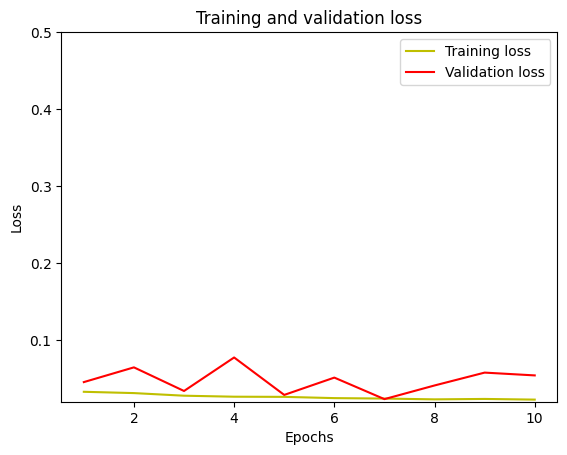

In [36]:
#plot training i validation loss-a
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(ymax=0.5)
plt.legend()
plt.show()

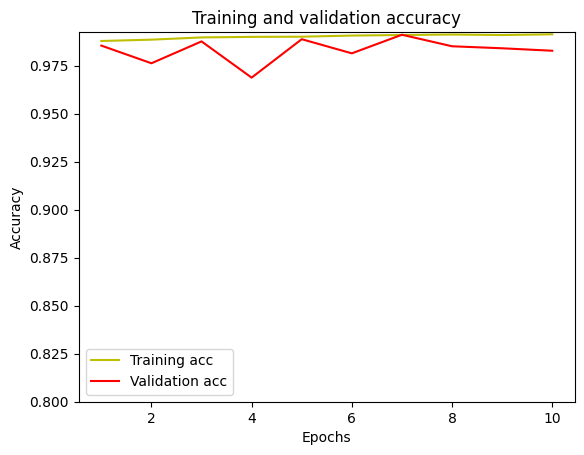

In [35]:
# plot training i validation accuracy-ja
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(ymin=0.8)
plt.legend()
plt.show()


In [28]:
# Intersection over Union kao bolja metrika za segmentacione modele
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.6

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

16/16 [==============================] - 8s 535ms/step
IoU socre is:  0.7942692393213429


1/1 [==============================] - 0s 31ms/step


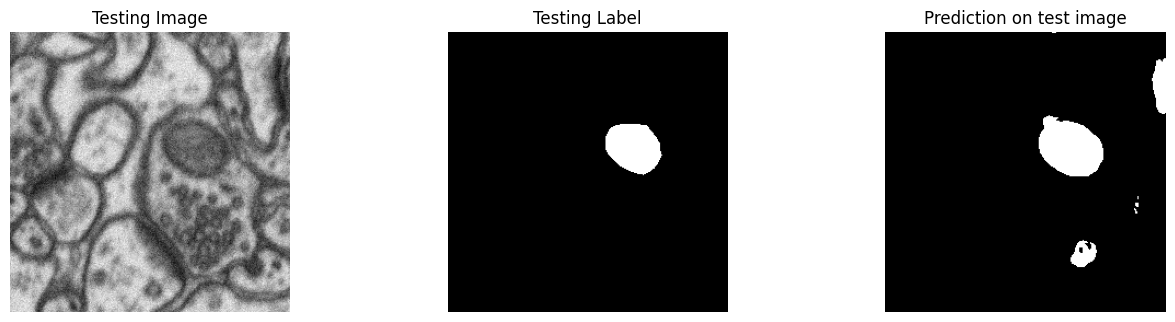

In [42]:
# Prikaz originalne slike, originalne maske i predviđene maske

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.axis('off')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.axis('off')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.axis('off')

plt.show()